In [2]:
# Pull game and player performance data from official NBA via api

In [3]:
pip install nba_api scipy statsmodels matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import necessary toolsets
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playercareerstats, playergamelog
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season, SeasonType
from nba_api.stats.static import players
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Function to retrieve regular season stats for a given player
def get_regular_season_data(player_id, season):
    # Fetch game logs for the specified season
    regular_stats = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star='Regular Season')
    regular_season_df = regular_stats.get_data_frames()[0]
    return regular_season_df

# Function to get playoff performance stats for a player
def get_playoff_data(player_id, season):
    # Fetch playoff game logs for the specified season
    playoff_stats = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star='Playoffs')
    playoff_stats_df = playoff_stats.get_data_frames()[0]
    return playoff_stats_df

# Function to get a player's ID from their name
def get_player_id(player_name):
    player = players.find_players_by_full_name(player_name)
    if player:
        return player[0]["id"]
    return None

In [6]:
# Sample list of players for analysis
player_names = ['LeBron James', 'Jimmy Butler', 'Giannis Antetokounmpo', 'Kawhi Leonard', 'Devin Booker', 'Joel Embiid']
player_data = []

# Set the season for analysis
season = '2020'

# Loop through each player to gather their data
for player_name in player_names:
    player_id = get_player_id(player_name)
    
    if player_id:
        # Get regular season data (minutes played, games played, etc.)
        regular_season_data = get_regular_season_data(player_id, season)
        
        # Get playoff data (points scored, assists, etc.)
        playoff_data = get_playoff_data(player_id, season)
        
        # Total minutes played during the regular season
        total_regular_season_minutes = regular_season_data['MIN'].sum()
        
        # Calculate average points scored in the playoffs
        avg_playoff_points = playoff_data['PTS'].mean()
        
        # Store the data for the player
        player_data.append({
            'player_name': player_name,
            'total_regular_season_minutes': total_regular_season_minutes,
            'avg_playoff_points': avg_playoff_points,
            'games_played': regular_season_data.shape[0]
        })

# Convert the collected player data into a DataFrame
player_df = pd.DataFrame(player_data)

In [7]:
# Define the threshold for rest (players with less than 2000 minutes in the regular season are considered "rested")
rest_threshold = 2000

# Categorize players into "rested" or "not rested" based on their total regular season minutes
player_df['rested_group'] = player_df['total_regular_season_minutes'].apply(
    lambda x: 'Rested' if x < rest_threshold else 'Not Rested'
)

In [8]:
# Perform a t-test to compare average playoff points between the two groups
rested_group = player_df[player_df['rested_group'] == 'Rested']['avg_playoff_points']
not_rested_group = player_df[player_df['rested_group'] == 'Not Rested']['avg_playoff_points']

# Calculate the t-statistic and p-value for the t-test
t_stat, p_value = stats.ttest_ind(rested_group, not_rested_group)

# Display the t-test results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value to determine if there's a significant difference
if p_value < 0.05:
    print("There is a statistically significant difference in playoff performance between rested and non-rested players.")
else:
    print("There is no statistically significant difference in playoff performance between rested and non-rested players.")

T-statistic: -0.8769992311186717
P-value: 0.4300017843198044
There is no statistically significant difference in playoff performance between rested and non-rested players.


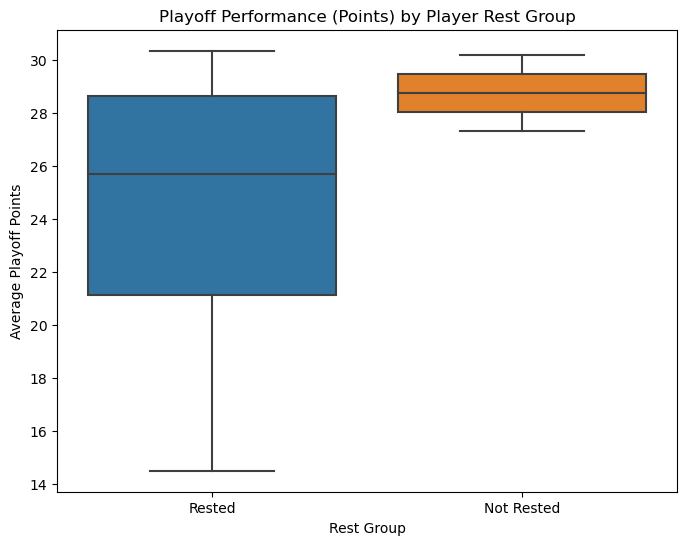

In [9]:
# Create a boxplot to visualize the performance differences between the two groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='rested_group', y='avg_playoff_points', data=player_df)
plt.title('Playoff Performance (Points) by Player Rest Group')
plt.xlabel('Rest Group')
plt.ylabel('Average Playoff Points')
plt.show()